In [0]:
import numpy as np
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#read data into a sparse matrix
def read_data(rating_file):
    rating_df = pd.read_table(rating_file,sep='\t',header=None,names=['userId','movieId','rating','timestamp'])
    rating_df = rating_df.drop(['timestamp'],axis=1)
    full_data_df=pd.pivot_table(rating_df,index=["userId"],values=["rating"],columns=["movieId"],fill_value=0)
    user_average = pd.pivot_table(rating_df,index=["userId"],values=["rating"],aggfunc=np.mean).values
    return full_data_df,user_average

In [0]:
#decomposite the rating matrix to three matrix
def svd_decomposition(data_matrix,number_of_components):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=number_of_components,n_iter=7,random_state=42)
    U=svd.fit_transform(data_matrix)
    variance_array =  svd.explained_variance_ratio_
    VT=svd.components_
    variance_matrix = pd.DataFrame(np.zeros((number_of_components,number_of_components)))
    variance_matrix.values[[np.arange(number_of_components)]*2] = variance_array
    variance_matrix=variance_matrix.values
    return U,variance_matrix,VT

In [0]:
def fit(filename,number_of_components=7):
    full_data_df,user_average = read_data(filename)
    U,S,V = svd_decomposition(full_data_df,number_of_components)
    return U,S,V,user_average

In [0]:
#do prediction
def predict(user_average,U,variance_matrix,VT,userId = 0,movieId=0):
    return user_average[userId]+np.dot(np.dot(U[userId],variance_matrix),VT[:,movieId])

In [0]:
#get the list of all movie id
def get_movie_list(filename):
    item_df = pd.read_csv(filename,sep='|',header=None,names=['movieId', 'title','release_date',"abc",'video',
            '0' , '1' , '2' , '3' ,'4','5',
            '6','7','8','9','10','11','12','13',
            '14','15','16','17','18'],encoding='latin-1')
    item_df_columns_to_drop=["release_date","abc",'video','0' , '1' , '2' , '3' ,'4','5',
            '6','7','8','9','10','11','12','13',
            '14','15','16','17','18']
    item_df=item_df.drop(item_df_columns_to_drop,axis=1)
    return item_df

In [0]:
#function to recommend 10 movies for a given user id 
def recommend(user_id,user_average,U,S,V,movie_list,movieId_title_dict,k):
    ranking_list=[]
    for movieId in movie_list:
        ranking_list.append(predict(user_average,U,S,V,user_id,movieId[0]-1)[0])
    top_k_value=sorted(ranking_list)[len(movie_list)-k:]
    all_movie_list = np.array(ranking_list).reshape((len(movie_list),1))
    index_list=[]
    for i in top_k_value[::-1]:
        index_list.extend(np.where(all_movie_list==i)[0])
    print("Herea are your recommendations:")
    index_number=1
    for i in index_list:
        print(index_number,".",movieId_title_dict[i+1]) 
        index_number+=1

In [0]:
file_1="/content/drive/My Drive/comp9417-project/SVD baseline/ml-100k/u.data"
movie_file="/content/drive/My Drive/comp9417-project/SVD baseline/ml-100k/u.item"
U,variance_matrix,VT,user_average = fit(file_1)
movie_list = get_movie_list(movie_file)
#movie id - name dictionary
movieId_title_dict=movie_list.set_index('movieId')['title'].to_dict()
movie_list=movie_list.values
#recommend 10 movies for one user
recommend(8,user_average,U,variance_matrix,VT,movie_list,movieId_title_dict,10)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Herea are your recommendations:
1 . Star Wars (1977)
2 . Fargo (1996)
3 . Return of the Jedi (1983)
4 . Godfather, The (1972)
5 . Contact (1997)
6 . Raiders of the Lost Ark (1981)
7 . Silence of the Lambs, The (1991)
8 . English Patient, The (1996)
9 . Toy Story (1995)
10 . Pulp Fiction (1994)


MSE validation:

In [0]:
def MSE_validation():
    path='/content/drive/My Drive/comp9417-project/SVD baseline'
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    file_test_1=[path+"/ml-100k/u1.base",path+"/ml-100k/u2.base",path+"/ml-100k/u3.base",path+"/ml-100k/u4.base",path+"/ml-100k/u5.base"]
    file_test_2=[path+"/ml-100k/u1.test",path+"/ml-100k/u2.test",path+"/ml-100k/u3.test",path+"/ml-100k/u4.test",path+"/ml-100k/u5.test"]
    file_test_3=["u1.test","u2.test","u3.test","u4.test","u5.test"]
    MSE = []
    for i in range(len(file_test_1)):
        U,variance_matrix,VT,user_average = fit(file_test_1[i])
        test_2_df = pd.read_table(file_test_2[i],sep='\t',header=None,names=['userId','movieId','rating','timestamp'])
        test_2_df=test_2_df.drop(["timestamp"],axis=1)
        target = test_2_df['rating'].values
        test_case = test_2_df.drop(["rating"],axis=1).values
        predict_array=[]
        for j in range(len(test_case)):
            try:
                predict_array.append(predict(user_average,U,variance_matrix,VT,test_case[j][0],test_case[j][1])[0])
            except:
                predict_array.append(0)
                target[j]=0
        if len(target) == len(predict_array):
            MSE.append(mean_squared_error(target,predict_array))
    print("MSE is:",np.mean(MSE))
    print("RMSE is:",np.mean(np.sqrt(MSE)))
    plt.plot(file_test_3,MSE)
    plt.scatter(file_test_3,MSE,color='red')
    plt.xlabel("dataset")
    plt.ylabel("MSE")
    plt.ylim(0,2)
    plt.title('Baseline SVD MSE')
    plt.savefig(path+'/mse-fig.jpg')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_csv instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

MSE is: 1.4720963647304306
RMSE is: 1.21323431086003


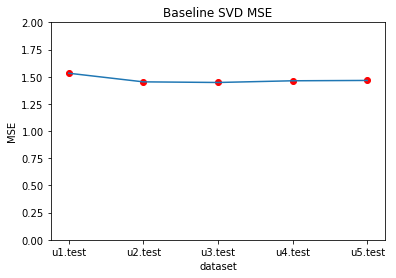

In [0]:
MSE_validation()